In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs

import random

import functions_timescale as funcs

In [2]:
#### User input ####

## Minimal intensity to select region where high-velocity gas originates
min_intensity = 100. ## based on the PDR Toolbox, imposes a minimal FUV field of G0~10^3
min_intensity_out = 3.*np.sqrt(50)*0.5 ## 50 spectral bins with an rms of ~0.5 K (3-sigma cut-off)

## sample size
sampleSize = 10000

## Input to extract the M42 region of interest from the Orion A map
x1_M42 = 260
x2_M42 = 260+720
y1_M42 = 20
y2_M42 = 20+640


## Input for the studied regions
## Value list:
## 0: distance to the region
## 1: velocity weighted outflow velocity (in km/s which is basically pc/Myr)
## 2: cluster age in Myr
## -3: right ascension in hh:mm:ss or decimal form
## -2: declination in deg:mm:ss or decimal form
## -1: name of the region
names = {
    'm16_CII_final_20_8_0p5_clean': [1706., 8.04, 1.3, 274.67, -13.78, 'M16'],
    'm17_CII_final_20_8_0p5_clean': [1900., 13.0, 0.58, 275.1, -16.16, 'M17'],
    'RCW120_CII_final_20_8_0p5_clean': [1680., 11.7, 1.2, '17:12:20.8', '-38:29:25.5', 'RCW 120'],
    'RCW79_CII_final_20_8_0p5_clean': [3900., 9.7, 2.3, '13:40:09.1', '-61:43:51.9', 'RCW 79'],
    'RCW36_CII_final_20_8_0p5_clean': [950., 8.05, 1.1, '08:59:29.0', '-43:45:06.0', 'RCW 36'],
    'W40_CII_final_20_8_0p5_clean': [502., 9.91, 0.9, '18:31:27.83', '-02:05:23.7', 'W40'],
    'NGC7538_CII_final_20_8_0p5_clean': [2650., 10.7, 2.2, '23:13:34.5', '61:30:14.3', 'NGC 7538'],
    #'RCW49_CII_final_20_8_0p5_clean': [4160., 12.2, '', '', 'RCW 49'],
    #'OrionA_CII_final_20_8_0p5_clean': [414., '05:35:16.46', '-05:23:22.8', 'M42'], 
}

#####################

### support functions

In [3]:
## return all integrated intensity data
## Assumes that all data is at the same resolution and grid
def get_itg_int(name):
    ## total integrated intensity
    hdu = pyfits.open('../data_timescale/integrated/'+name+'_integrated.fits')
    data, header = hdu[0].data, hdu[0].header
    w = wcs.WCS(header)
    
    ## blue wing
    hdu = pyfits.open('../data_timescale/integrated/'+name+'_blue.fits')
    data_B = hdu[0].data
    
    ## red wing
    hdu = pyfits.open('../data_timescale/integrated/'+name+'_red.fits')
    data_R = hdu[0].data
    
    ## Remove all the unnecessary data from a map
    if(name == 'OrionA_CII_final_20_8_0p5_clean'):
        data = funcs.extract_region_in_map(data,x1_M42,x2_M42,y1_M42,y2_M42)
        data_B = funcs.extract_region_in_map(data_B,x1_M42,x2_M42,y1_M42,y2_M42)
        data_R = funcs.extract_region_in_map(data_R,x1_M42,x2_M42,y1_M42,y2_M42)
    
    return data, data_B, data_R, header, w
    

In [4]:
## function that converts right ascencion and declination coordinates from hh/dd:mm:ss string format to decimal angle format
def WCStoDecimal(val1, val2):
    ## split the hh:mm:ss coordinates
    val1Res = val1.split(':')
    val2Res = val2.split(':')
    
    ## convert to the decimal format
    ra = float(val1Res[0]) * 15. + float(val1Res[1]) * 15. / 60. + float(val1Res[2]) * 15. / 3600.
    dec = float(val2Res[0]) + float(val2Res[1]) / 60. + float(val2Res[2]) / 3600.
    if(float(val2Res[0]) < 0.):
        dec = float(val2Res[0]) - float(val2Res[1]) / 60. - float(val2Res[2]) / 3600.
        
    return ra, dec

### Perform the actual calculations

0.543548003068359


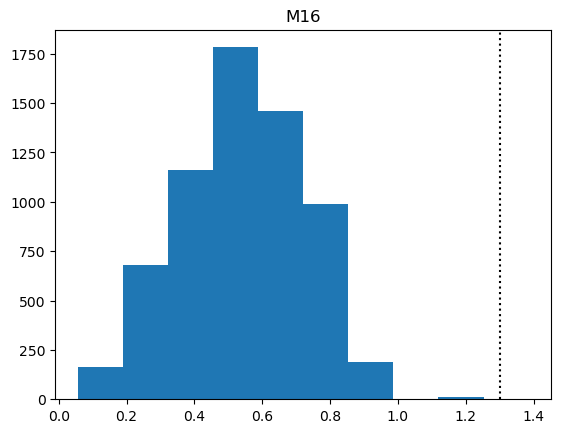

0.30530808754447797


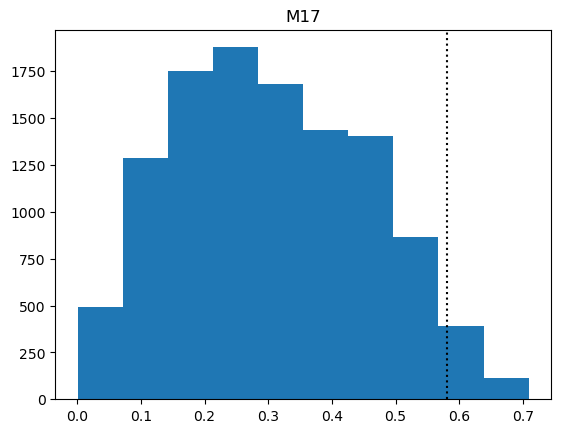

0.22276991279681121


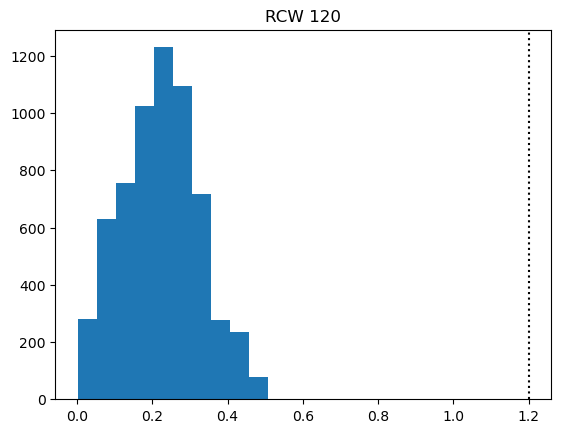

0.6395128932760261


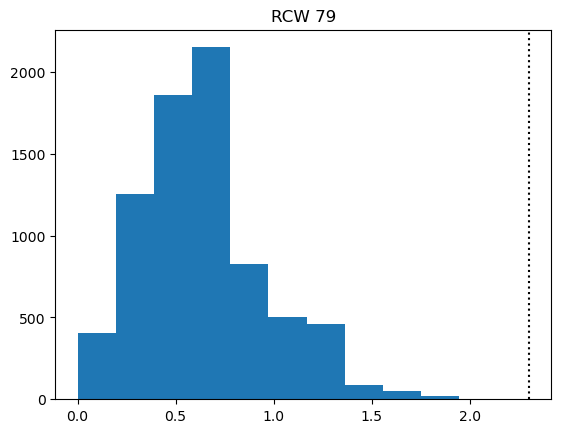

0.08776592335980005


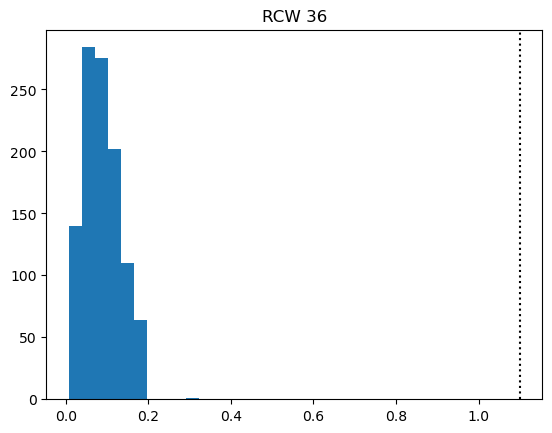

0.08658141551612257


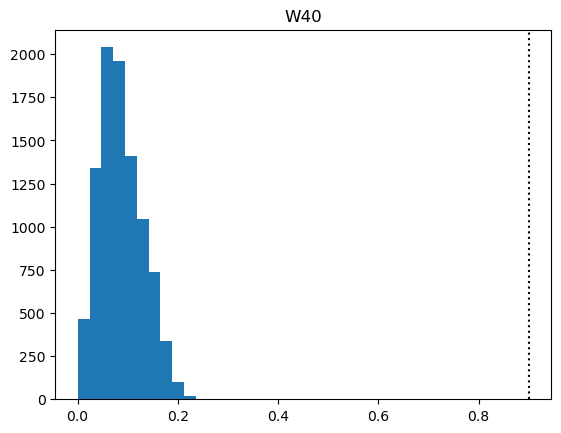

0.3079238639589732


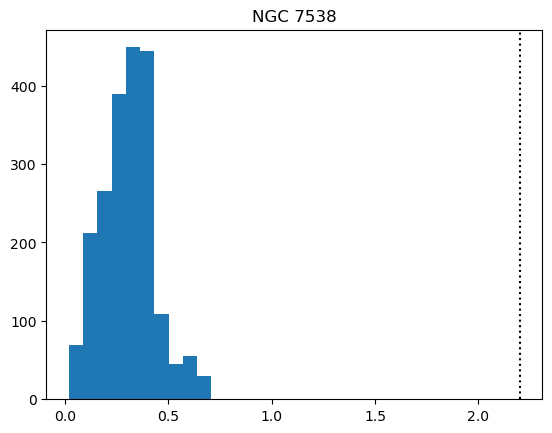

In [5]:
## loop over all regions
for name in names:
    
    ## open the integrated intensity fits files and get the pixel size in pc
    data, data_B, data_R, header, w = get_itg_int(name)
    pix_size = names[name][0]*header['CDELT2']*np.pi/180.
    
    ## sum the wings together and set detection cut off + get the pixel indices of the detected outflowing gas
    data_out = data_B + data_R
    data_out[data_out < min_intensity_out] = np.nan
    inds_out = np.argwhere(~np.isnan(data_out))
    
    ## get the ra & dec of the cluster and ensure it is in decimal form
    ## then get the pixel coordinates of the cluster
    ra, dec = names[name][-3], names[name][-2]
    if(isinstance(ra, str)): ra, dec = WCStoDecimal(ra, dec)
    pix_clus = w.wcs_world2pix(np.array([[ra, dec]]), 1)
    pix_clus = pix_clus[0]
    
    ## calculate the distance from the cluster to the outflow
    diff_clus_pix = (inds_out - pix_clus)*pix_size
    diff_clus_pc = np.zeros(shape = diff_clus_pix.shape[0])
    for i, pix in enumerate(diff_clus_pix): diff_clus_pc[i] = np.sqrt(pix[0]**2 + pix[1]**2)
    
    ## convert the distance to timescale distribution based on the intensity weighted outflow velocity
    dt_clus = diff_clus_pc / names[name][1]
    print(np.nanmean(dt_clus))
    
    ## Plot of the timescale distribution using the cluster as reference
    plt.title(names[name][-1])
    plt.hist(dt_clus)
    plt.axvline(x = names[name][2], linestyle = ':', color = 'k')
    #plt.hist(diff_clus_pc)
    #plt.imshow(data_out)
    plt.show()
    
    ## verification plots
    #plt.hist(diff_clus_pc)
    #plt.imshow(data_out)
    
    
    # STILL REMOVE ORION FROM AROUND M42 CUBE
    
    